# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule, TomekLinks, RandomUnderSampler

import category_encoders as ce

In [2]:
def evalue_model(model, y_test, X_test, model_name):
    
    yhat_prob = [x[1] for x in model.predict_proba(X_test)]
    
    results = {'model': model_name,
               'auc': roc_auc_score(y_true = y_test, y_score = yhat_prob),
               'aucpr': average_precision_score(y_true = y_test, y_score = yhat_prob),
               'logloss': log_loss(y_test, yhat_prob)}
    
    return results

In [3]:
submission = pd.read_csv('../input/tabular-playground-series-mar-2021/sample_submission.csv')
new_data = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
df = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')

In [4]:
#profile = df.profile_report(title="Profile train.csv", explorative=True)
#profile.to_file(output_file="profile_report.html")

In [5]:
df.drop(columns = "id", inplace = True)
new_data.drop(columns = "id", inplace = True)

In [6]:
for col in df.columns[df.dtypes == "object"].tolist():
    df[col] = df[col].astype('category')

# Prepare Data

In [7]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
high_cardinality = ["cat5", "cat7", "cat8", "cat10"]

categorical_cols = X.columns[X.dtypes == "category"].tolist()

categorical_cols = list(set(categorical_cols) - set(high_cardinality))

cat_columns_position = [X.columns.tolist().index(x) for x in categorical_cols + high_cardinality]

# Baseline Models

In [9]:
categorical_transformer = Pipeline(steps=[
   # ('OrdinalEncoder', ce.OrdinalEncoder(cols=categorical_cols + high_cardinality))
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = 999))
    #('TargetEncoder', ce.TargetEncoder(cols=high_cardinality))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols + high_cardinality)
])

undersample = RandomUnderSampler(sampling_strategy='majority')

In [10]:
# Desicion Tree ----------------------------------------
model_tree = DecisionTreeClassifier(random_state = 42)

pipe_tree = Pipeline([('preprocessor', preprocessor),
                      ('clf', model_tree )])

pipe_tree_un = Pipeline([('preprocessor', preprocessor),
                         ('undersample', undersample),
                         ('clf', model_tree )])

# Random Forest ----------------------------------------
model_rf = RandomForestClassifier(random_state = 42, n_jobs=-1)

pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('clf', model_rf )])

pipe_rf_un = Pipeline([('preprocessor', preprocessor),
                       ('undersample', undersample),
                       ('clf', model_rf )])

# LightGBM ---------------------------------------------
model_lgbm = LGBMClassifier(random_state = 42, 
                            device = "gpu", 
                            n_estimators = 500)

pipe_lgbm = Pipeline([('preprocessor', preprocessor),
                      ('clf', model_lgbm )])

pipe_lgbm_un = Pipeline([('preprocessor', preprocessor),
                         ('undersample', undersample),
                         ('clf', model_lgbm )])

# CatBoost ----------------------------------------------
model_cat = CatBoostClassifier(random_state = 42, verbose = 0,
                               task_type="GPU", border_count = 32,
                                n_estimators = 500,
                                early_stopping_rounds = 100)

pipe_cat = Pipeline([('clf', model_cat )])

pipe_cat_un = Pipeline([('undersample', undersample),
                        ('clf', model_cat )])

# CatBoost (fast mode)----------------------------------
model_cat_fast = CatBoostClassifier(random_seed=42, verbose = 0,
                                    task_type="GPU", border_count = 32, # turn on gpu
                                    n_estimators = 500,
                                     boosting_type = "Plain",
                                     bootstrap_type = "Bernoulli",
                                     max_ctr_complexity = 1,
                                     subsample = 0.6,
                                     #colsample_bylevel = 0.5, # ONLY CPU
                                     #one_hot_max_size = 4,
                                     #leaf_estimation_iterations = 5, #[1,10]
                                     early_stopping_rounds = 100)

pipe_cat_fast = Pipeline([('clf', model_cat_fast )])

pipe_cat_fast_un = Pipeline([('undersample', undersample),
                             ('clf', model_cat_fast )])

In [11]:
classifiers = {
    "DecisionTreeClassifier": pipe_tree,
    "DecisionTreeClassifier_un": pipe_tree_un,
    "RandomForestClassifier": pipe_rf,
    "RandomForestClassifier_un": pipe_rf_un,
    "LGBMClassifier": pipe_lgbm,
    "LGBMClassifier_un": pipe_lgbm_un,
    "CatBoostClassifier": pipe_cat,
    "CatBoostClassifier_un": pipe_cat_un,
    "CatBoostClassifier_fast": pipe_cat_fast,
    "CatBoostClassifier_fast_un": pipe_cat_fast_un
}

In [12]:
results = pd.DataFrame(columns= ["model", "auc", "aucpr", "logloss",  "time"])

In [13]:
%%time

import time

for key, classifier in classifiers.items():
    print("Running", key)
    
    start_time = time.time()
    
    if key.find("LGBMClassifier") != -1:
        classifiers[key] = classifier.fit(X_train, y_train, clf__categorical_feature = cat_columns_position)
    elif key.find("CatBoostClassifier") != -1:
        classifiers[key] = classifier.fit(X_train, y_train, clf__cat_features = cat_columns_position)
    else:
        classifiers[key] = classifier.fit(X_train, y_train)

    end_time = (time.time() - start_time)

    results = results.append(
        pd.concat([
        pd.DataFrame(evalue_model(classifiers[key], y_test, X_test, key), index=[0]),
        pd.DataFrame({"time" : end_time}, index = [0]) ],
        axis=1)
    )

Running DecisionTreeClassifier
Running DecisionTreeClassifier_un
Running RandomForestClassifier
Running RandomForestClassifier_un
Running LGBMClassifier


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Running LGBMClassifier_un


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Running CatBoostClassifier
Running CatBoostClassifier_un
Running CatBoostClassifier_fast
Running CatBoostClassifier_fast_un
CPU times: user 4min 36s, sys: 18.6 s, total: 4min 54s
Wall time: 3min 34s


In [14]:
results.sort_values(by=['auc'], ascending = False)

,model,auc,aucpr,logloss,time
0,CatBoostClassifier_fast_un,0.889978,0.783907,0.415708,10.582134
0,CatBoostClassifier_fast,0.889469,0.785135,0.351202,10.716575
0,CatBoostClassifier,0.887654,0.781164,0.354235,84.804311
0,CatBoostClassifier_un,0.887511,0.778835,0.418003,22.704176
0,LGBMClassifier,0.884387,0.775620,0.358807,16.088659
0,LGBMClassifier_un,0.882450,0.769712,0.427368,8.034112
0,RandomForestClassifier_un,0.862284,0.726314,0.561822,13.623294
0,RandomForestClassifier,0.860380,0.733585,0.546284,27.053407
0,DecisionTreeClassifier_un,0.721743,0.427562,9.084113,2.623575
0,DecisionTreeClassifier,0.714695,0.455737,7.230536,3.435738


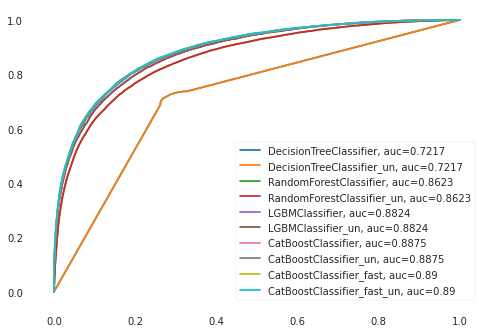

In [15]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

for key, classifier in classifiers.items():
    
    yhat_prob = [x[1] for x in classifier.predict_proba(X_test)]

    fpr, tpr, thresh = metrics.roc_curve(y_true = y_test, y_score = yhat_prob)
    auc = metrics.roc_auc_score(y_test, yhat_prob)
    plt.plot(fpr,tpr,label=key+", auc="+str(round(auc, 4)))
    
plt.legend(loc=0)

# Bayes Tunning

In [16]:
# eval dataset to lgbm
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [17]:
hp_space = {
    'undersample': hp.choice(label = 'undersample', options = [True, False]),
    'clf': {
        #'n_estimators': ho_scope.int(hp.quniform('n_estimators',200,600,100)), 

        'max_depth':  ho_scope.int(hp.quniform('max_depth',1,9,1)),
        #'leaf_estimation_iterations':  ho_scope.int(hp.quniform('leaf_estimation_iterations',1,5,1)),
        
        'subsample': hp.uniform('colsample_bytree',0.2,0.7),
        #'colsample_bylevel': hp.uniform('colsample_bylevel',0.2,0.6),
        
        'reg_lambda': hp.loguniform('reg_lambda',np.log(1e-4),np.log(7))
        
        # catboost 
       # 'border_count': hp.choice(label = 'border_count', options = [32, 64 ,128, 254]) # turn off on gpu
        #'ctr_target_border_count': hp.choice(label = 'ctr_target_border_count', options = [1,5,10,20,50,100,200, 250])
    }
}

ho_sample(hp_space)

{'clf': {'max_depth': 8,
  'reg_lambda': 1.9554917329170782,
  'subsample': 0.3126465537644695},
 'undersample': False}

In [18]:
iteracoes = Trials()

In [19]:
def instancia_modelo(hiperparametros):
        
    clf = CatBoostClassifier(**hiperparametros['clf'],
                             random_seed=42, verbose = 0,
                             task_type="GPU", border_count = 32, # turn on gpu
                             boosting_type = "Plain",
                             bootstrap_type = "Bernoulli",
                             max_ctr_complexity = 0,
                             n_estimators = 550,
                             early_stopping_rounds = 100)

    if hiperparametros['undersample'] == True:
        undersample = RandomUnderSampler(sampling_strategy='majority')

    else:
        undersample = None
        
    #categorical_transformer = Pipeline(steps=[
    #    ('OrdinalEncoder', ce.OrdinalEncoder(cols=categorical_cols)),
    #    ('JamesSteinEncoder', ce.JamesSteinEncoder(cols=high_cardinality))
    #])

    #preprocessor = ColumnTransformer(
    #    transformers=[
    #        #('num', numerical_transformer, numerical_cols),
    #        ('cat', categorical_transformer, high_cardinality + categorical_cols)
    #])
    
    pipe = Pipeline([#('preprocessor', preprocessor),
                       ('undersample', undersample),
                       ('clf', clf) ])

    return pipe

In [20]:
## criando uma função para realizar o treino do modelo
def funcao_para_minimizar(hiperparametros, features, target):
    
    ## criando uma instancia do modelo com a combinação definida de hiperparametros para usar dentro da função
    pipe = instancia_modelo(hiperparametros)
    
    #pipe.named_steps.preprocessor.fit(X_train, y_train)
    #X_val_interim = pipe.named_steps.preprocessor.transform(X_val)
    # Usando dados de validacao
    
    #eval_set = [X_val, y_val]
    
    #fit_params={'clf__early_stopping_rounds': 100, 
    #            'clf__eval_metric': 'auc',
    #            'clf__verbose': False,
    #            'clf__categorical_feature': categorical_cols + high_cardinality,
    #            'clf__eval_set': eval_set}
    
    fit_params={'clf__cat_features':cat_columns_position}
    
    cv = StratifiedKFold(n_splits=5)
    
    ## treinando o modelo com cross-validation
    resultado = cross_val_score(estimator = pipe, 
                                X = features, 
                                y = target, 
                                scoring = "roc_auc",
                                cv = cv, 
                                error_score = "raise",
                                fit_params = fit_params,
                                n_jobs = -1)
    
    ## retornando a metrica da performance do modelo
    return -resultado.mean()

In [21]:
%%time

## rodando a otimização
otimizacao = fmin(fn = partial(funcao_para_minimizar, features = X_train, target = y_train),
                  space = hp_space, 
                  algo = tpe.suggest,
                  trials = iteracoes,
                  max_evals = int(120), 
                  rstate = np.random.RandomState(42))

100%|██████████| 120/120 [3:39:10<00:00, 109.59s/trial, best loss: -0.8911124643210313]
CPU times: user 1min 41s, sys: 5min 3s, total: 6min 45s
Wall time: 3h 39min 10s


In [22]:
def extrai_space_eval(hp_space, trial):
    ## desempacota o resultado
    desempacota_trial = space_eval(space = hp_space, 
                                   hp_assignment = {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})
    
    ## retornando o resultado
    return desempacota_trial

In [23]:

def desempacota_dicionario(dicionario):
    desempacotado = {}
    for (chave, valor) in dicionario.items():
        if isinstance(valor, dict):
            desempacotado = {**desempacotado, **desempacota_dicionario(valor)}
        else:
            desempacotado[chave] = valor
            
    return desempacotado

In [24]:
## colocando o historico em um dataframe
historico = pd.DataFrame([desempacota_dicionario(extrai_space_eval(hp_space, x)) for x in iteracoes.trials])

## colocando o AUC como uma das colunas
historico['auc'] = [-x['loss'] for x in iteracoes.results]

In [25]:
# hiperparâmetros selecionados pela otimização
hiperparametros_selecionados = space_eval(space = hp_space, hp_assignment = otimizacao)
print('Hiperparâmetros selecionados:\n%s' % hiperparametros_selecionados)

Hiperparâmetros selecionados:
{'clf': {'max_depth': 9, 'reg_lambda': 3.851903811191025, 'subsample': 0.671382036954592}, 'undersample': False}


In [26]:
import plotly.express as px

historico.loc[:,'undersample'] = historico.loc[:,'undersample']*1


fig = px.parallel_coordinates(historico, color="auc")
fig.show()

In [27]:
%%time

# Local results
modelo_final = instancia_modelo(hiperparametros=hiperparametros_selecionados)
modelo_final = modelo_final.fit(X_train, y_train, clf__cat_features=cat_columns_position)

results = results.append(pd.DataFrame(evalue_model(modelo_final, y_test, X_test, "final_model"), index=[0]))
results.sort_values(by=['auc'], ascending = False)

CPU times: user 32.1 s, sys: 4.82 s, total: 36.9 s
Wall time: 29.3 s


,model,auc,aucpr,logloss,time
0,final_model,0.890993,0.787530,0.348870,NaN
0,CatBoostClassifier_fast_un,0.889978,0.783907,0.415708,10.582134
0,CatBoostClassifier_fast,0.889469,0.785135,0.351202,10.716575
0,CatBoostClassifier,0.887654,0.781164,0.354235,84.804311
0,CatBoostClassifier_un,0.887511,0.778835,0.418003,22.704176
0,LGBMClassifier,0.884387,0.775620,0.358807,16.088659
0,LGBMClassifier_un,0.882450,0.769712,0.427368,8.034112
0,RandomForestClassifier_un,0.862284,0.726314,0.561822,13.623294
0,RandomForestClassifier,0.860380,0.733585,0.546284,27.053407
0,DecisionTreeClassifier_un,0.721743,0.427562,9.084113,2.623575


In [28]:
%%time

# Submit results
clf = CatBoostClassifier(**hiperparametros_selecionados['clf'],
                         random_seed=42, verbose = 0, task_type="GPU", border_count = 32,
                         bootstrap_type = "Bernoulli",
                         n_estimators = 3000,
                         early_stopping_rounds = 100)
    
pipe = Pipeline([#('preprocessor', preprocessor),
                 ('undersample', undersample),
                 ('clf', clf) ])

final_fit = pipe.fit(X, y, clf__cat_features=cat_columns_position)

submission.loc[:, 'target'] = final_fit.predict_proba(new_data)[:,1]
submission.to_csv('submission.csv', index = False)

CPU times: user 5min 12s, sys: 39.2 s, total: 5min 52s
Wall time: 4min 33s
